In [ ]:
# installation des librairies
!pip install pandas numpy matplotlib seaborn scikit-learn --quiet


**1 Justification du choix du dataset:**



*  Le dataset general_results.csv (résultats électoraux – data.gouv.fr) a été choisi car il s’agit de données officielles, fiables et ouvertes, issues du Ministère de l’Intérieur. Il contient un grand volume d’observations (niveau bureau de vote), ce qui permet une analyse exploratoire approfondie.

*  Le jeu de données comprend de nombreuses variables quantitatives (inscrits, abstentions, votants, blancs, nuls, exprimés, pourcentages) ainsi que plusieurs variables catégorielles (département, commune, canton, circonscription), et une forte dimension géographique.

*  Il permet d’analyser des enjeux stratégiques majeurs tels que la participation électorale, l’abstention et les disparités territoriales, tout en offrant un terrain pertinent pour la détection de patterns et de signaux faibles (zones de désengagement électoral).

**Limites :**
- Données agrégées (bureaux de vote) : pas de variables socio-démographiques, donc on ne peut pas expliquer “pourquoi” en profondeur.
- Les résultats dépendent du contexte local (organisation, taille des bureaux), ce qui peut créer des valeurs atypiques.

**Biais potentiels :**
- Les bureaux de vote n’ont pas la même taille (inscrits), donc une moyenne simple peut masquer des différences.
- On analyse uniquement 2022 (T1/T2) : conclusions limitées à ce scrutin.


**2 Construction d’une problématique analytique**

Question de recherche :

 *Quels facteurs géographiques et démographiques semblent associés à la participation électorale et aux votes blancs ou nuls dans les communes françaises ?*

Explication :

*   On ne cherche pas à prédire, mais à comprendre les dynamiques de participation.

*   On peut analyser l’effet de taille du corps électoral, type de commune ou département sur :

1.  l’abstention
2.   la part de votes blancs/nuls





*   On peut également détecter des signaux faibles, comme des bureaux de vote atypiques ou des zones à faible engagement.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)


## 3) Chargement des données (périmètre 2022)

On charge un extrait du dataset et on se concentre sur la présidentielle 2022 (Tour 1 & Tour 2) pour l’analyse.


In [ ]:
url = "https://object.files.data.gouv.fr/data-pipeline-open/elections/general_results.csv"
df = pd.read_csv(url, sep=";", encoding="utf-8",nrows=10000)
# Vérification rapide
print(df.shape)
print(df.dtypes)
df.head()


(10000, 25)
id_election                       object
id_brut_miom                      object
Code du département                int64
Libellé du département            object
Code de la commune                 int64
Libellé de la commune             object
Code du b.vote                   float64
Inscrits                           int64
Abstentions                        int64
% Abs/Ins                        float64
Votants                            int64
% Vot/Ins                        float64
Blancs                             int64
% Blancs/Ins                     float64
% Blancs/Vot                     float64
Nuls                               int64
% Nuls/Ins                       float64
% Nuls/Vot                       float64
Exprimés                           int64
% Exp/Ins                        float64
% Exp/Vot                        float64
Code de la circonscription       float64
Libellé de la circonscription    float64
Code du canton                   float64
Libe

,id_election,id_brut_miom,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,Code de la circonscription,Libellé de la circonscription,Code du canton,Libellé du canton
0,2019_euro_t1,01001_0001,1,Ain,1,L'Abergement-Clémenciat,1.0,601,268,44.59,333,55.41,1,0.17,0.30,18,3.00,5.41,314,52.25,94.29,NaN,NaN,NaN,NaN
1,2019_euro_t1,01002_0001,1,Ain,2,L'Abergement-De-Varey,1.0,210,69,32.86,141,67.14,4,1.90,2.84,2,0.95,1.42,135,64.29,95.74,NaN,NaN,NaN,NaN
2,2019_euro_t1,01004_0001,1,Ain,4,Ambérieu-En-Bugey,1.0,1050,548,52.19,502,47.81,15,1.43,2.99,13,1.24,2.59,474,45.14,94.42,NaN,NaN,NaN,NaN
3,2019_euro_t1,01004_0002,1,Ain,4,Ambérieu-En-Bugey,2.0,1106,527,47.65,579,52.35,15,1.36,2.59,24,2.17,4.15,540,48.82,93.26,NaN,NaN,NaN,NaN
4,2019_euro_t1,01004_0003,1,Ain,4,Ambérieu-En-Bugey,3.0,1058,485,45.84,573,54.16,14,1.32,2.44,8,0.76,1.40,551,52.08,96.16,NaN,NaN,NaN,NaN


## 4) Préparation et nettoyage des données

Objectifs : contrôler la qualité (valeurs manquantes, doublons, types), corriger si besoin, puis créer des variables utiles (taux, catégories) pour l’EDA.




Préparation et nettoyage des données

In [ ]:
# ===============================
# a) Analyse de la qualité des données
# ===============================

# 1. Valeurs manquantes
missing = df.isna().sum()
print("\nValeurs manquantes par colonne:\n", missing)

# 2. Doublons
print("\nNombre de doublons:", df.duplicated().sum())

# 3. Types incohérents
print("\nTypes de colonnes:\n", df.dtypes)



Valeurs manquantes par colonne:
 id_election                          0
id_brut_miom                         0
Code du département                  0
Libellé du département               0
Code de la commune                   0
Libellé de la commune                0
Code du b.vote                       0
Inscrits                             0
Abstentions                          0
% Abs/Ins                            0
Votants                              0
% Vot/Ins                            0
Blancs                               0
% Blancs/Ins                         0
% Blancs/Vot                         0
Nuls                                 0
% Nuls/Ins                           0
% Nuls/Vot                           0
Exprimés                             0
% Exp/Ins                            0
% Exp/Vot                            0
Code de la circonscription       10000
Libellé de la circonscription    10000
Code du canton                   10000
Libellé du canton             

Suppression des colonnes vides

In [ ]:
# Supprimer les colonnes quasi vides
missing_rate = df.isna().mean().sort_values(ascending=False)
cols_to_drop = missing_rate[missing_rate > 0.95].index.tolist()

print("Colonnes supprimées ( >95% manquantes ) :", cols_to_drop)
df = df.drop(columns=cols_to_drop)


Colonnes supprimées ( >95% manquantes ) : ['Code de la circonscription', 'Libellé du canton', 'Code du canton', 'Libellé de la circonscription']


Remplire les cellules vides

In [ ]:
# Remplir "Libellé du département" s'il est vide à partir du "Code du département"
if "Libellé du département" in df.columns and "Code du département" in df.columns:
    mapping_dept = (
        df.dropna(subset=["Libellé du département"])
          .drop_duplicates("Code du département")
          .set_index("Code du département")["Libellé du département"]
    )
    df["Libellé du département"] = df["Libellé du département"].fillna(df["Code du département"].map(mapping_dept))

print("Missing après remplissage :", df["Libellé du département"].isna().mean())


Missing après remplissage : 0.0


Gestion des doublons

In [ ]:
key_cols = [c for c in ["id_election", "id_brut_miom"] if c in df.columns]
before = df.shape[0]
df = df.drop_duplicates(subset=key_cols, keep="first")
print("Doublons supprimés :", before - df.shape[0])

Doublons supprimés : 0


Contrôles de cohérence métier

In [ ]:
# Règle 1 : Votants = Inscrits - Abstentions
mask1 = (df["Votants"] != (df["Inscrits"] - df["Abstentions"]))
print("Incohérences Votants = Inscrits - Abstentions :", mask1.sum())

# Règle 2 : Blancs + Nuls + Exprimés <= Votants
mask2 = (df["Blancs"] + df["Nuls"] + df["Exprimés"] > df["Votants"])
print("Incohérences (Blancs+Nuls+Expr) <= Votants :", mask2.sum())


Incohérences Votants = Inscrits - Abstentions : 0
Incohérences (Blancs+Nuls+Expr) <= Votants : 0


Création de variables dérivées

In [ ]:
df["taux_participation_calc"] = np.where(df["Inscrits"] > 0, df["Votants"] / df["Inscrits"], np.nan)
df["taux_abstention_calc"] = np.where(df["Inscrits"] > 0, df["Abstentions"] / df["Inscrits"], np.nan)
df["taux_blancs_votants_calc"] = np.where(df["Votants"] > 0, df["Blancs"] / df["Votants"], np.nan)
df["taux_nuls_votants_calc"] = np.where(df["Votants"] > 0, df["Nuls"] / df["Votants"], np.nan)

# Exemple : écart entre tes calculs et les colonnes officielles (qualité)
df["delta_abstention"] = df["taux_abstention_calc"]*100 - df["% Abs/Ins"]
print(df["delta_abstention"].describe())


count    10000.000000
mean        -0.000039
std          0.002876
min         -0.005000
25%         -0.002553
50%          0.000000
75%          0.002488
max          0.004994
Name: delta_abstention, dtype: float64


Création de catégories (transformation)

In [ ]:
df["classe_abstention"] = pd.cut(
    df["taux_abstention_calc"],
    bins=[0, 0.25, 0.40, 0.55, 1.0],
    labels=["faible", "moyenne", "élevée", "très élevée"],
    include_lowest=True
)

df["taille_bureau"] = pd.cut(
    df["Inscrits"],
    bins=[0, 500, 1000, 2000, 1000000],
    labels=["petit", "moyen", "grand", "très grand"],
    include_lowest=True
)

In [ ]:
# 4. Outliers (exemple: % Abstention)
# Pourcentages logiques : 0 à 100
pct_cols = [c for c in df.columns if c.startswith("%")]
for c in pct_cols:
    df[c] = df[c].clip(lower=0, upper=100)

# Taux calculés : 0 à 1
rate_cols = ["taux_participation_calc", "taux_abstention_calc", "taux_blancs_votants_calc", "taux_nuls_votants_calc"]
for c in rate_cols:
    df[c] = df[c].clip(lower=0, upper=1)


In [ ]:
print("Shape finale :", df.shape)
print("Missing final (%) :", (df.isna().mean()*100).round(2).sort_values(ascending=False).head(10))

df.to_csv("general_results_clean.csv", index=False)


Shape finale : (10000, 28)
Missing final (%) : id_election               0.0
id_brut_miom              0.0
Code du département       0.0
Libellé du département    0.0
Code de la commune        0.0
Libellé de la commune     0.0
Code du b.vote            0.0
Inscrits                  0.0
Abstentions               0.0
% Abs/Ins                 0.0
dtype: float64


In [ ]:
ELECTIONS = ["2022_pres_t1", "2022_pres_t2"]

chunks = []
for chunk in pd.read_csv(url, sep=";", encoding="utf-8", chunksize=300000):
    chunk = chunk[chunk["id_election"].isin(ELECTIONS)]
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
print(df.shape)


/tmp/ipython-input-3944121829.py:4: DtypeWarning: Columns (2,6,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(url, sep=";", encoding="utf-8", chunksize=300000):
/tmp/ipython-input-3944121829.py:4: DtypeWarning: Columns (2,6,22,24) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(url, sep=";", encoding="utf-8", chunksize=300000):
/tmp/ipython-input-3944121829.py:4: DtypeWarning: Columns (2,6,22) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(url, sep=";", encoding="utf-8", chunksize=300000):
/tmp/ipython-input-3944121829.py:4: DtypeWarning: Columns (2,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(url, sep=";", encoding="utf-8", chunksize=300000):
/tmp/ipython-input-3944121829.py:4: DtypeWarning: Columns (2,3,6) have mixed types. Specify dtype option on import or s

(139364, 25)


In [ ]:
# Codes géo en texte (évite la perte de zéros)
for col in ["Code du département", "Code de la commune", "Code du b.vote"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Colonnes de comptage en numérique
count_cols = ["Inscrits","Abstentions","Votants","Blancs","Nuls","Exprimés"]
for c in count_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Pourcentages en numérique (si certains sont lus en texte)
pct_cols = [c for c in df.columns if c.startswith("%")]
for c in pct_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [ ]:
# On ne peut pas calculer les taux si ces champs sont manquants
before = df.shape[0]
df = df.dropna(subset=["Inscrits", "Votants", "Abstentions"])
print("Lignes supprimées (NA colonnes clés) :", before - df.shape[0])


Lignes supprimées (NA colonnes clés) : 0


In [ ]:
df["flag_incoh_votants"] = (df["Votants"] != (df["Inscrits"] - df["Abstentions"]))
df["flag_incoh_votes"] = (df["Blancs"] + df["Nuls"] + df["Exprimés"] > df["Votants"])

print(df[["flag_incoh_votants","flag_incoh_votes"]].mean()*100)

# Dataset "analyse" sans incohérences (si tu choisis de les exclure)
df_ana = df[~(df["flag_incoh_votants"] | df["flag_incoh_votes"])].copy()


flag_incoh_votants    0.0
flag_incoh_votes      0.0
dtype: float64


In [ ]:
df_viz = df_ana.copy() if "df_ana" in globals() else df.copy()

#Présidentielle 2022 T1/T2
ELECTIONS = ["2022_pres_t1", "2022_pres_t2"]
if "id_election" in df_viz.columns:
    df_viz = df_viz[df_viz["id_election"].isin(ELECTIONS)].copy()

print("Shape df_viz :", df_viz.shape)
display(df_viz.head())


Shape df_viz : (139364, 27)


,id_election,id_brut_miom,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,Code de la circonscription,Libellé de la circonscription,Code du canton,Libellé du canton,flag_incoh_votants,flag_incoh_votes
0,2022_pres_t2,01001_0001,01,Ain,1,L'Abergement-Clémenciat,0001,643,146,22.71,497,77.29,42.0,6.53,8.45,5,0.78,1.01,450,69.98,90.54,4.0,4Ème Circonscription,NaN,NaN,False,False
1,2022_pres_t2,01002_0001,01,Ain,2,L'Abergement-De-Varey,0001,213,45,21.13,168,78.87,23.0,10.80,13.69,3,1.41,1.79,142,66.67,84.52,5.0,5Ème Circonscription,NaN,NaN,False,False
2,2022_pres_t2,01004_0001,01,Ain,4,Ambérieu-En-Bugey,0001,1130,322,28.50,808,71.50,71.0,6.28,8.79,22,1.95,2.72,715,63.27,88.49,5.0,5Ème Circonscription,NaN,NaN,False,False
3,2022_pres_t2,01004_0002,01,Ain,4,Ambérieu-En-Bugey,0002,1129,313,27.72,816,72.28,45.0,3.99,5.51,18,1.59,2.21,753,66.70,92.28,5.0,5Ème Circonscription,NaN,NaN,False,False
4,2022_pres_t2,01004_0003,01,Ain,4,Ambérieu-En-Bugey,0003,1213,303,24.98,910,75.02,87.0,7.17,9.56,21,1.73,2.31,802,66.12,88.13,5.0,5Ème Circonscription,NaN,NaN,False,False


 ## 5) Statistiques descriptives

Avant les graphes, on résume les tendances globales (moyennes/dispersion) et quelques comparaisons simples.

In [ ]:
# Si tes taux ne sont pas encore en % (0-100), crée-les ici
if "abstention_pct_calc" not in df_viz.columns and "taux_abstention_calc" in df_viz.columns:
    df_viz["abstention_pct_calc"] = (df_viz["taux_abstention_calc"] * 100).clip(0, 100)

if "participation_pct_calc" not in df_viz.columns and "taux_participation_calc" in df_viz.columns:
    df_viz["participation_pct_calc"] = (df_viz["taux_participation_calc"] * 100).clip(0, 100)

if "blancs_pct_votants_calc" not in df_viz.columns and "taux_blancs_votants_calc" in df_viz.columns:
    df_viz["blancs_pct_votants_calc"] = (df_viz["taux_blancs_votants_calc"] * 100).clip(0, 100)

if "nuls_pct_votants_calc" not in df_viz.columns and "taux_nuls_votants_calc" in df_viz.columns:
    df_viz["nuls_pct_votants_calc"] = (df_viz["taux_nuls_votants_calc"] * 100).clip(0, 100)

rate_cols = ["abstention_pct_calc","participation_pct_calc","blancs_pct_votants_calc","nuls_pct_votants_calc"]
rate_cols = [c for c in rate_cols if c in df_viz.columns]

for c in rate_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df_viz[c].dropna(), bins=40, kde=True)
    plt.title(f"Distribution — {c}")
    plt.xlabel(c)
    plt.ylabel("Nombre de bureaux de vote")
    plt.tight_layout()
    plt.show()


In [ ]:

# Tableau EDA : résumé des pourcentages officiels (si colonnes calculées absentes)

cols = [c for c in ["% Vot/Ins", "% Abs/Ins", "% Blancs/Vot", "% Nuls/Vot"] if c in df_viz.columns]

print("Colonnes :", cols)
display(df_viz[cols].describe().round(2))

display(df_viz.groupby("id_election")[cols].mean().round(2))


Colonnes : ['% Vot/Ins', '% Abs/Ins', '% Blancs/Vot', '% Nuls/Vot']


,% Vot/Ins,% Abs/Ins,% Blancs/Vot,% Nuls/Vot
count,139364.00,139364.00,139364.00,139364.00
mean,75.18,24.81,4.13,1.65
std,10.01,9.97,3.40,2.81
min,0.00,0.00,0.00,0.00
25%,72.24,19.03,1.42,0.48
50%,77.30,22.70,3.10,1.18
75%,80.97,27.75,6.38,2.25
max,100.00,100.00,100.00,100.00


,% Vot/Ins,% Abs/Ins,% Blancs/Vot,% Nuls/Vot
id_election,,,,
2022_pres_t1,75.87,24.12,1.58,0.78
2022_pres_t2,74.49,25.49,6.68,2.52


## Export du dataset nettoyé en format CSV


In [2]:
df_viz.to_csv("general_results_clean.csv", index=False)
print("Export du fichier nettoyé : general_results_clean.csv")

from google.colab import files
files.download("general_results_clean.csv")


NameError: name 'df_viz' is not defined

## 6. Visualisations
### Graphique 1 — Corrélations (heatmap)
Objectif : repérer les relations entre les indicateurs (abstention, participation, blancs, nuls).


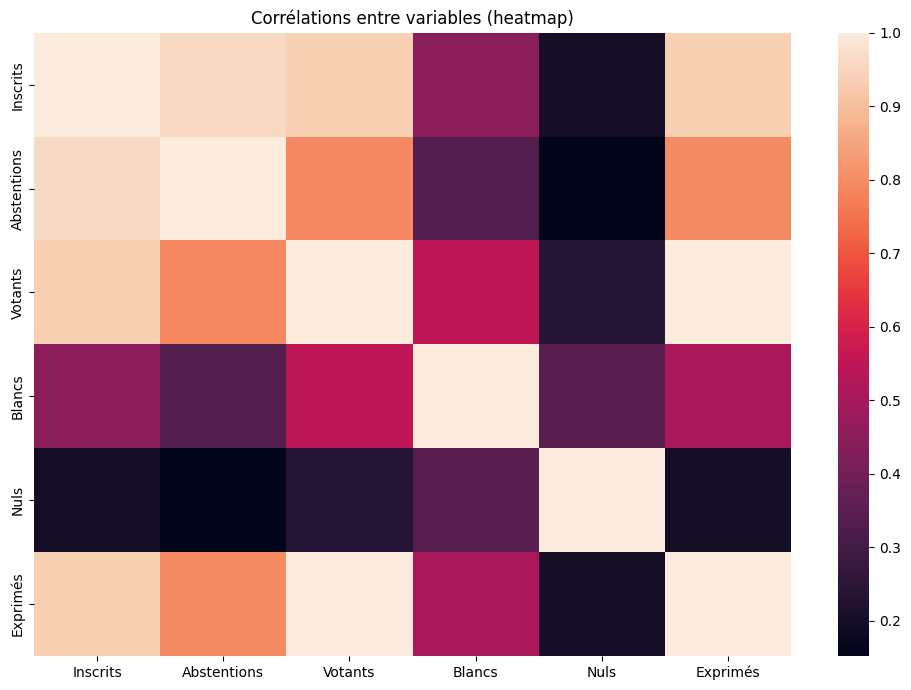

In [ ]:
#Graphe 1 — Corrélations

num_candidates = [
    "Inscrits","Abstentions","Votants","Blancs","Nuls","Exprimés",
    "abstention_pct_calc","participation_pct_calc","blancs_pct_votants_calc","nuls_pct_votants_calc"
]
num_cols = [c for c in num_candidates if c in df_viz.columns]
corr = df_viz[num_cols].dropna().corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=False)
plt.title("Corrélations entre variables (heatmap)")
plt.tight_layout()
plt.show()



### Graphique 2 — Top 15 départements (abstention moyenne)
Objectif : comparer l’abstention moyenne entre les départements.


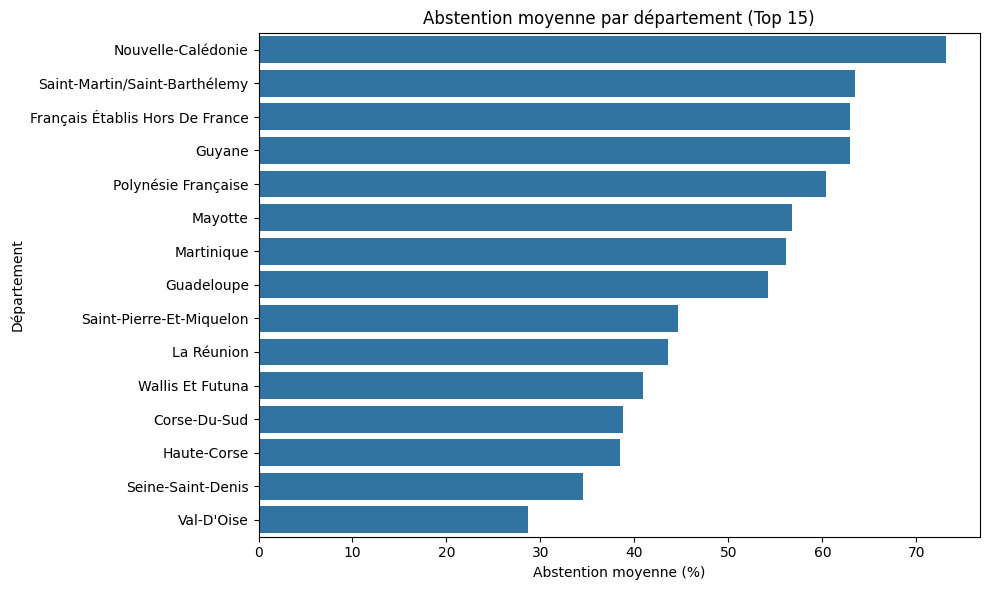

In [ ]:
# Graphique 2 — Abstention moyenne par département (Top 15)

df_plot = df_viz.copy()

# Ensure taux_abstention_calc is present
if "taux_abstention_calc" not in df_plot.columns:
    df_plot["taux_abstention_calc"] = np.where(
        df_plot["Inscrits"] > 0,
        pd.to_numeric(df_plot["Abstentions"], errors="coerce") / pd.to_numeric(df_plot["Inscrits"], errors="coerce"),
        np.nan
    )

# Then ensure abstention_pct_calc is present
if "abstention_pct_calc" not in df_plot.columns:
    df_plot["abstention_pct_calc"] = (df_plot["taux_abstention_calc"] * 100).clip(0, 100)

if "Libellé du département" in df_plot.columns:
    df_plot["dept_label"] = df_plot["Libellé du département"].fillna(df_plot["Code du département"])
else:
    df_plot["dept_label"] = df_plot["Code du département"]

# Ensure abstention_pct_calc is numeric before grouping
df_plot["abstention_pct_calc"] = pd.to_numeric(df_plot["abstention_pct_calc"], errors="coerce")

dept_mean = (df_plot.groupby("dept_label")["abstention_pct_calc"]
             .mean()
             .dropna()
             .sort_values(ascending=False)
             .head(15))

plt.figure(figsize=(10, 6))
sns.barplot(x=dept_mean.values, y=dept_mean.index)
plt.title("Abstention moyenne par département (Top 15)")
plt.xlabel("Abstention moyenne (%)")
plt.ylabel("Département")
plt.tight_layout()
plt.show()

### Graphique 3 — Distribution de l’abstention
Objectif : observer la dispersion de l’abstention et repérer les valeurs fréquentes.


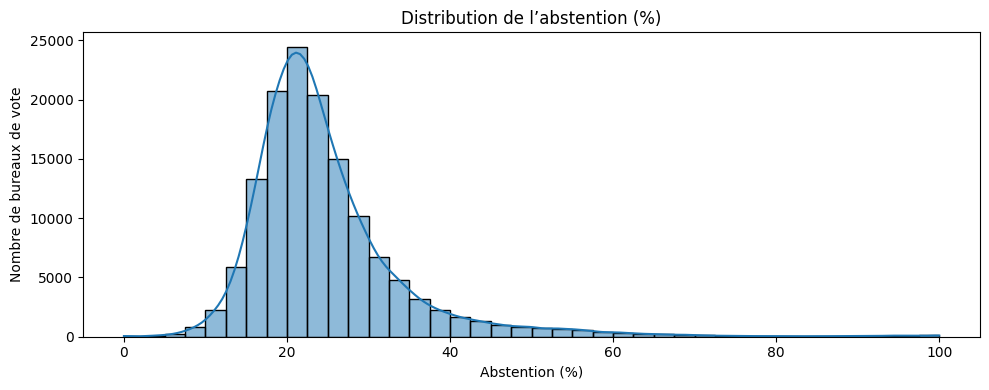

In [ ]:
# graphe 3: Filtre présidentielles 2022
ELECTIONS = ["2022_pres_t1", "2022_pres_t2"]
if "id_election" in df_plot.columns:
    df_plot = df_plot[df_plot["id_election"].isin(ELECTIONS)].copy()

# Colonne abstention %
if "abstention_pct_calc" in df_plot.columns:
    abst = pd.to_numeric(df_plot["abstention_pct_calc"], errors="coerce")
elif "taux_abstention_calc" in df_plot.columns:
    abst = pd.to_numeric(df_plot["taux_abstention_calc"], errors="coerce") * 100
else:
    abst = pd.to_numeric(df_plot["% Abs/Ins"], errors="coerce")

abst = abst.clip(0, 100).dropna()

plt.figure(figsize=(10, 4))
sns.histplot(abst, bins=40, kde=True)
plt.title("Distribution de l’abstention (%)")
plt.xlabel("Abstention (%)")
plt.ylabel("Nombre de bureaux de vote")
plt.tight_layout()
plt.show()

### Graphique 4 — Abstention vs Blancs
Objectif : vérifier s’il existe une relation entre l’abstention et le vote blanc.


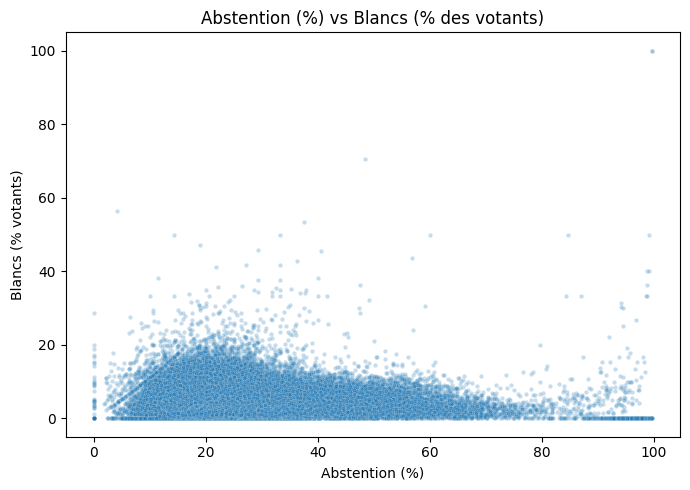

In [ ]:
# Graphique 4 — Abstention (%) vs Blancs (% des votants)

# Ensure taux_abstention_calc is present
if "taux_abstention_calc" not in df_viz.columns:
    df_viz["taux_abstention_calc"] = np.where(
        df_viz["Inscrits"] > 0,
        pd.to_numeric(df_viz["Abstentions"], errors="coerce") / pd.to_numeric(df_viz["Inscrits"], errors="coerce"),
        np.nan
    )

# Ensure abstention_pct_calc is present
if "abstention_pct_calc" not in df_viz.columns:
    df_viz["abstention_pct_calc"] = (df_viz["taux_abstention_calc"] * 100).clip(0, 100)

# Ensure taux_blancs_votants_calc is present
if "taux_blancs_votants_calc" not in df_viz.columns:
    df_viz["taux_blancs_votants_calc"] = np.where(
        df_viz["Votants"] > 0,
        pd.to_numeric(df_viz["Blancs"], errors="coerce") / pd.to_numeric(df_viz["Votants"], errors="coerce"),
        np.nan
    )

# Ensure blancs_pct_votants_calc is present
if "blancs_pct_votants_calc" not in df_viz.columns:
    df_viz["blancs_pct_votants_calc"] = (df_viz["taux_blancs_votants_calc"] * 100).clip(0, 100)

tmp = df_viz[["abstention_pct_calc", "blancs_pct_votants_calc"]].copy()
tmp["abstention_pct_calc"] = pd.to_numeric(tmp["abstention_pct_calc"], errors="coerce")
tmp["blancs_pct_votants_calc"] = pd.to_numeric(tmp["blancs_pct_votants_calc"], errors="coerce")
tmp = tmp.dropna()

MAX_POINTS = 200000
if len(tmp) > MAX_POINTS:
    tmp = tmp.sample(MAX_POINTS, random_state=42)

plt.figure(figsize=(7, 5))
sns.scatterplot(data=tmp, x="abstention_pct_calc", y="blancs_pct_votants_calc", s=10, alpha=0.25)
plt.title("Abstention (%) vs Blancs (% des votants)")
plt.xlabel("Abstention (%)")
plt.ylabel("Blancs (% votants)")
plt.tight_layout()
plt.show()

### Graphique 5 — Abstention selon la taille du bureau
Objectif : analyser une relation entre une catégorie (taille du bureau) et l’abstention.


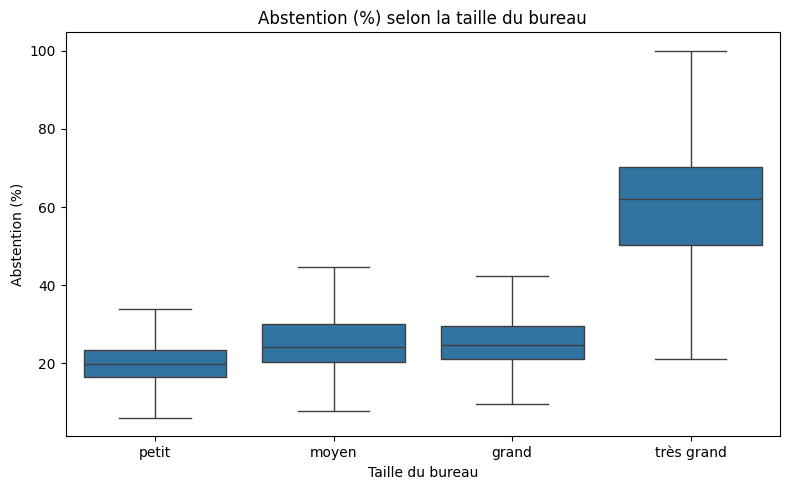

In [ ]:
# graphe 5: Abstention (%) selon la taille du bureau (Inscrits): Analyse croisée

df_plot = df_viz.copy()

if "taille_bureau" not in df_plot.columns:
    df_plot["taille_bureau"] = pd.cut(
        pd.to_numeric(df_plot["Inscrits"], errors="coerce"),
        bins=[0, 500, 1000, 2000, 10**9],
        labels=["petit", "moyen", "grand", "très grand"],
        include_lowest=True
    )

# Recalculate taux_abstention_calc and abstention_pct_calc if they don't exist
if "taux_abstention_calc" not in df_plot.columns:
    df_plot["taux_abstention_calc"] = np.where(
        df_plot["Inscrits"] > 0,
        pd.to_numeric(df_plot["Abstentions"], errors="coerce") / pd.to_numeric(df_plot["Inscrits"], errors="coerce"),
        np.nan
    )

if "abstention_pct_calc" not in df_plot.columns:
    df_plot["abstention_pct_calc"] = (df_plot["taux_abstention_calc"] * 100).clip(0, 100)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_plot, x="taille_bureau", y="abstention_pct_calc", showfliers=False)
plt.title("Abstention (%) selon la taille du bureau")
plt.xlabel("Taille du bureau")
plt.ylabel("Abstention (%)")
plt.tight_layout()
plt.show()

### Graphique 6 — Segmentation (taille du bureau × classe d’abstention)
Objectif : visualiser un regroupement simple en croisant deux catégories (pattern).


/tmp/ipython-input-3015275986.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_viz, x="classe_abstention", palette="viridis")


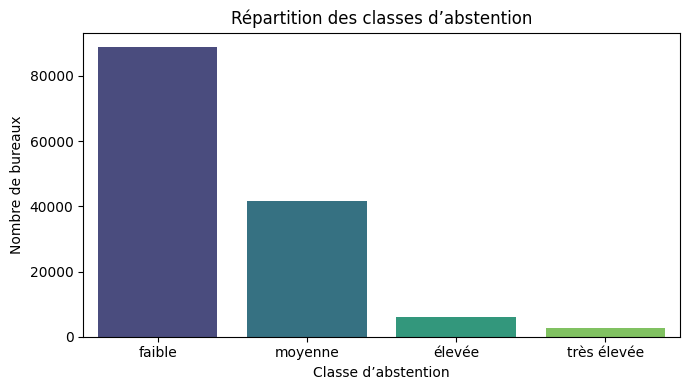

In [ ]:

if "taux_abstention_calc" not in df_viz.columns:
    df_viz["taux_abstention_calc"] = np.where(
        df_viz["Inscrits"] > 0,
        df_viz["Abstentions"] / df_viz["Inscrits"],
        np.nan
    )
if "abstention_pct_calc" not in df_viz.columns:
    df_viz["abstention_pct_calc"] = (df_viz["taux_abstention_calc"] * 100).clip(0, 100)

# Create 'classe_abstention' if it does not exist in df_viz
if "classe_abstention" not in df_viz.columns:
    df_viz["classe_abstention"] = pd.cut(
        pd.to_numeric(df_viz["abstention_pct_calc"], errors="coerce"),
        bins=[0, 25, 40, 55, 100],
        labels=["faible", "moyenne", "élevée", "très élevée"],
        include_lowest=True
    )

plt.figure(figsize=(7,4))
sns.countplot(data=df_viz, x="classe_abstention", palette="viridis")
plt.title("Répartition des classes d’abstention")
plt.xlabel("Classe d’abstention")
plt.ylabel("Nombre de bureaux")
plt.tight_layout()
plt.show()

## 6. Chiffres clés
Cette partie calcule quelques valeurs simples pour appuyer les insights (moyennes, écarts, corrélations).


In [ ]:
print("Chiffres clés")

# Ensure all percentage columns are calculated before use
# taux_abstention_calc and abstention_pct_calc should already be present from previous steps

# Ensure taux_participation_calc and participation_pct_calc
if "taux_participation_calc" not in df_viz.columns:
    df_viz["taux_participation_calc"] = np.where(
        df_viz["Inscrits"] > 0,
        pd.to_numeric(df_viz["Votants"], errors="coerce") / pd.to_numeric(df_viz["Inscrits"], errors="coerce"),
        np.nan
    )
if "participation_pct_calc" not in df_viz.columns:
    df_viz["participation_pct_calc"] = (df_viz["taux_participation_calc"] * 100).clip(0, 100)

# Ensure taux_nuls_votants_calc and nuls_pct_votants_calc
if "taux_nuls_votants_calc" not in df_viz.columns:
    df_viz["taux_nuls_votants_calc"] = np.where(
        df_viz["Votants"] > 0,
        pd.to_numeric(df_viz["Nuls"], errors="coerce") / pd.to_numeric(df_viz["Votants"], errors="coerce"),
        np.nan
    )
if "nuls_pct_votants_calc" not in df_viz.columns:
    df_viz["nuls_pct_votants_calc"] = (df_viz["taux_nuls_votants_calc"] * 100).clip(0, 100)

# Moyennes par tour
means = df_viz.groupby("id_election")[["participation_pct_calc","abstention_pct_calc","blancs_pct_votants_calc","nuls_pct_votants_calc"]].mean()
display(means)

# Différence T2 - T1 (si les deux existent)
if "2022_pres_t1" in means.index and "2022_pres_t2" in means.index:
    delta = means.loc["2022_pres_t2"] - means.loc["2022_pres_t1"]
    print("Delta (T2 - T1) :")
    display(delta)

# Corrélation abstention vs blancs
tmp = df_viz[["abstention_pct_calc","blancs_pct_votants_calc"]].dropna()
print("Corrélation abstention vs blancs :", tmp["abstention_pct_calc"].corr(tmp["blancs_pct_votants_calc"]))

Chiffres clés


,participation_pct_calc,abstention_pct_calc,blancs_pct_votants_calc,nuls_pct_votants_calc
id_election,,,,
2022_pres_t1,75.877338,24.122662,1.580470,0.775918
2022_pres_t2,74.503728,25.496272,6.684501,2.518288


Delta (T2 - T1) :


,0
participation_pct_calc,-1.37361
abstention_pct_calc,1.37361
blancs_pct_votants_calc,5.10403
nuls_pct_votants_calc,1.74237


Corrélation abstention vs blancs : 0.032934235951633445


## 7) Insight & Analyse stratégique (Présidentielle 2022 — T1 & T2)

**Insight 1 — Baisse de la participation au 2e tour**
En moyenne par bureau, la participation passe de **75,88 % (T1)** à **74,50 % (T2)**, soit **-1,37 point**.  
L’abstention augmente logiquement de **24,12 %** à **25,50 %**, soit **+1,37 point**.  
Cela montre une légère démobilisation au second tour.

**Insight 2 — Forte hausse des votes blancs et des votes nuls au 2e tour**
Le vote blanc (% des votants) passe de **1,58 % (T1)** à **6,68 % (T2)**, soit **+5,10 points**.  
Les votes nuls (% des votants) passent de **0,78 %** à **2,52 %**, soit **+1,74 point**.  
On a un signal très net de “vote de rejet” (blancs) et une hausse des bulletins invalidés (nuls).

**Insight 3 — Abstention très différente selon les territoires**
En Tour 2, les niveaux les plus élevés apparaissent surtout dans certains territoires / catégories spécifiques :  
- **Nouvelle-Calédonie ≈ 73,08 %**,  
- **Français établis hors de France ≈ 62,40 %**,  
- **Guyane ≈ 61,47 %** (ordre de grandeur).  
Si on regarde la France métropolitaine, on retrouve aussi des zones très hautes :  
- **Corse-du-Sud ≈ 40,21 %**, **Haute-Corse ≈ 39,54 %**, **Seine-Saint-Denis ≈ 38,81 %**.  
Conclusion : l’abstention n’est pas “nationale uniforme”, elle dépend fortement du contexte territorial.

**Insight 4 — “Poches” locales visibles dans la distribution**
Au Tour 2, la distribution de l’abstention par bureau est assez dispersée :  
- 1er quartile ≈ **19,62 %**, médiane ≈ **23,30 %**, 3e quartile ≈ **28,67 %**.  
Environ **7,42 %** des bureaux dépassent **40 %** d’abstention, et **2,94 %** dépassent **50 %**.  
Il existe donc des “poches” locales de très forte abstention, même si la médiane reste autour de 23 %.

**Insight 5 — Vote blanc très hétérogène selon les territoires**
Au Tour 2, le vote blanc (en % des votants) peut être très élevé dans certains départements, par exemple :  
- **Ariège ≈ 11,47 %**, **Hautes-Pyrénées ≈ 10,46 %**.  
À l’inverse, certains territoires sont très bas, par exemple :  
- **Wallis et Futuna ≈ 1,71 %**, **Polynésie française ≈ 2,36 %**, **Mayotte ≈ 3,93 %**.  
Le vote blanc n’a pas le même “sens” partout : il varie fortement selon les contextes locaux.

**Insight 6 — Effet de la taille des bureaux (Tour 2)**
Quand je segmente par taille (inscrits), l’abstention moyenne augmente avec la taille :  
- petits bureaux (≤ 500 inscrits) : **≈ 21,35 %**,  
- 501–1000 inscrits : **≈ 27,49 %**,  
- 1001–2000 inscrits : **≈ 27,89 %**.  
Les bureaux plus grands semblent associés à plus d’abstention (cela peut refléter des zones plus denses / urbaines, à confirmer).

**Insight 7 — Abstention et vote blanc : relation très faible**
La corrélation “abstention (%)” vs “blancs (% des votants)” est **faible** sur l’ensemble des bureaux : **r ≈ 0,03**.  
Et si on regarde par tour, elle reste faible (T1 ≈ 0,05 ; T2 ≈ -0,06).  
Abstention et vote blanc ne racontent pas exactement la même chose : ce sont deux comportements différents.

---

### Signaux faibles potentiels
- Certains profils reviennent souvent : **forte abstention + hausse des blancs/nuls** (possible défiance ou vote “contre”).  
- La forte abstention dans certains territoires spécifiques (outre-mer / Français de l’étranger) mérite une lecture séparée (logistique, accès au vote, distance, etc.).

---

### Contraintes méthodologiques (qualité des données / limites d’interprétation)
- Données **agrégées** : pas de variables socio-démographiques (âge, revenu, diplôme, densité…), donc on décrit des tendances sans expliquer les causes.  
- Analyse **descriptive** : corrélation ≠ causalité.  
- Les comparaisons “moyenne par bureau” ne sont pas les mêmes qu’un taux “pondéré par population” (les gros bureaux pèsent autant que les petits dans une moyenne simple).

---

### Interprétation stratégique (décideur) : implications et recommandations
**Implications (politiques publiques)**
- La hausse des blancs/nuls au Tour 2 peut être un indicateur de défiance : enjeu de confiance, de pédagogie, et d’accessibilité au vote.  
- Les écarts territoriaux montrent que les actions doivent être ciblées localement (pas uniquement nationales).

**Recommandations opérationnelles**
- Prioriser des actions de mobilisation dans les zones à forte abstention (communication locale, relais terrain, simplification des démarches).  
- Mettre une communication claire sur la validité du bulletin pour limiter les nuls (rappel simple avant le scrutin).  
- Suivre séparément : **abstention** (non-participation) vs **vote blanc** (participation + rejet), car ce ne sont pas les mêmes leviers.

**Axes d’amélioration / besoins en données complémentaires**
- Croiser avec des données INSEE (densité, âge, niveau de vie, mobilité) pour comprendre les écarts.  
- Comparer avec un autre scrutin (ex : 2017 vs 2022) pour distinguer ce qui est structurel de ce qui est conjoncturel.
